In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_7728/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

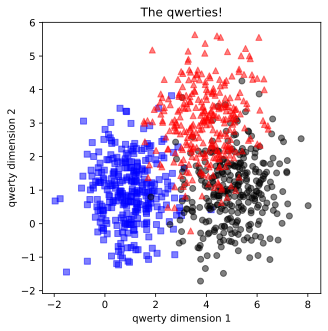

In [2]:
# Parameters
n_per_clust = 300
blur        = 1
A           = [1, 1]
B           = [5, 1]
C           = [4, 3]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

# Concatanate into a matrix
data_np   = np.hstack(tup=(a, b, c)).T

# True labels
labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                           np.ones(shape=(n_per_clust)),
                           1 + np.ones(shape=(n_per_clust))))

# Convert to a pytorch tensor
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=0.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=0.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=0.5)

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
train_batch_size = 16
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset,  batch_size=test_batch_size)

# How many batches are there?
print(f'There are {len(train_loader)} batches, each with {train_batch_size} samples')

There are 50 batches, each with 16 samples


# The model

In [4]:
def create_the_qwety_net(initial_LR):
    class qwerty_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(2, 8)

            # Hidden layer
            self.fc1 = nn.Linear(8, 8)

            # Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = self.output(x)

            return x
        
    # Create the model instance
    net = qwerty_net()
    
    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer  and LR scheduler
    optimizer = torch.optim.SGD(params=net.parameters(), lr=initial_LR)
    # Total number of datasamples in the training set
    step_size = train_batch_size * len(train_loader)
    # Call the `scheduler` `step_size` times before the LRate change
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=0.5)

    return net, loss_func, optimizer, scheduler

# # Test the model with optimizer type as input
# # Try 'SGD', 'RMSprop', and 'Adam'
# optim = create_the_qwety_net('RMSprop')[2]
# optim

# How many steps until the learning rate changes?
len(train_loader) * train_batch_size

800

# Explore the learning rate decay parameter

In [5]:
# Create a network
net = create_the_qwety_net(initial_LR=0.01)[0]

# A new optimizer
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.5)

# Test the change in learning rate
for epoch in range(3):
    for batch_num in range(10):
        print(f'Batch {batch_num}, epoch {epoch}: LR = {scheduler.get_last_lr()[0]}')
        scheduler.step()

Batch 0, epoch 0: LR = 0.01
Batch 1, epoch 0: LR = 0.01
Batch 2, epoch 0: LR = 0.01
Batch 3, epoch 0: LR = 0.01
Batch 4, epoch 0: LR = 0.01
Batch 5, epoch 0: LR = 0.005
Batch 6, epoch 0: LR = 0.005
Batch 7, epoch 0: LR = 0.005
Batch 8, epoch 0: LR = 0.005
Batch 9, epoch 0: LR = 0.005
Batch 0, epoch 1: LR = 0.0025
Batch 1, epoch 1: LR = 0.0025
Batch 2, epoch 1: LR = 0.0025
Batch 3, epoch 1: LR = 0.0025
Batch 4, epoch 1: LR = 0.0025
Batch 5, epoch 1: LR = 0.00125
Batch 6, epoch 1: LR = 0.00125
Batch 7, epoch 1: LR = 0.00125
Batch 8, epoch 1: LR = 0.00125
Batch 9, epoch 1: LR = 0.00125
Batch 0, epoch 2: LR = 0.000625
Batch 1, epoch 2: LR = 0.000625
Batch 2, epoch 2: LR = 0.000625
Batch 3, epoch 2: LR = 0.000625
Batch 4, epoch 2: LR = 0.000625
Batch 5, epoch 2: LR = 0.0003125
Batch 6, epoch 2: LR = 0.0003125
Batch 7, epoch 2: LR = 0.0003125
Batch 8, epoch 2: LR = 0.0003125
Batch 9, epoch 2: LR = 0.0003125


C:\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


# Training

In [6]:
num_epochs = 50

def train_the_model(initial_LR, toggle_dynamic_LR):
  
  net, loss_func, optimizer, scheduler = create_the_qwety_net(initial_LR=initial_LR)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  # Initialize losses
  losses = torch.zeros(num_epochs)

  current_LR = []

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Step the LR scheduler
      if toggle_dynamic_LR:
        scheduler.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

      current_LR.append(scheduler.get_last_lr()[0])

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      y_hat = net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses, net, current_LR

# Test that the model really changes (sanity checks)

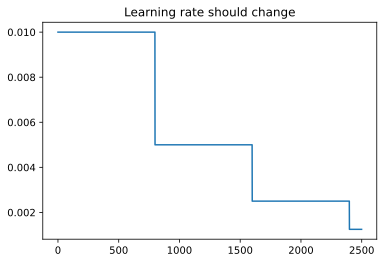

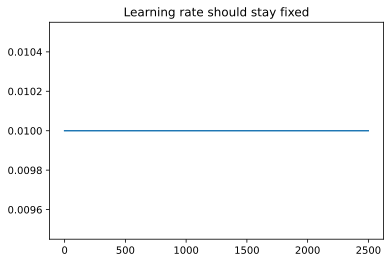

In [7]:
# Test that the learning rate is really working
train_acc, test_acc, losses, net, current_LR = train_the_model(initial_LR=0.01, toggle_dynamic_LR=True)
plt.plot(current_LR)
plt.title('Learning rate should change')
plt.show()

train_acc, test_acc, losses, net, current_LR = train_the_model(initial_LR=0.01, toggle_dynamic_LR=False)
plt.plot(current_LR)
plt.title('Learning rate should stay fixed')
plt.show()

# Now for the experiment!

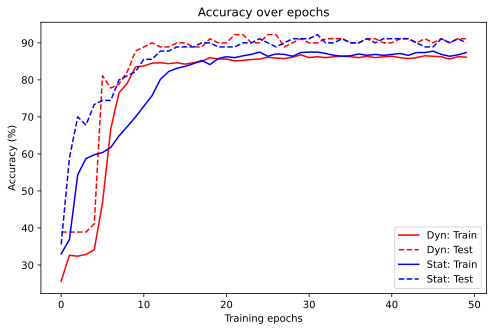

In [9]:
# Now test with and without dynamic LR
train_acc_dynamic, test_acc_dynamic, losses, net, current_LR = train_the_model(initial_LR=0.01, toggle_dynamic_LR=True)
train_acc_static,  test_acc_static,  losses, net, current_LR = train_the_model(initial_LR=0.01, toggle_dynamic_LR=False)

fig = plt.figure(figsize=(8, 5))
plt.plot(train_acc_dynamic, 'r',   label='Dyn: Train')
plt.plot(test_acc_dynamic,  'r--', label='Dyn: Test')

plt.plot(train_acc_static, 'b',   label='Stat: Train')
plt.plot(test_acc_static,  'b--', label='Stat: Test')

plt.xlabel('Training epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

# Additional explorations
1) When you run the experiment in the previous cell multiple times, you can get different answers. This indicates
   that the network and/or training regimen is not stable enough. What can you do to increase the stability of the
   model and training? That is, what can you change to make the results more similar each time you re-run the experiment?

2) There are several more options for dynamic learning rates in Pytorch. Try modifying the code!
      See https://pytorch.org/docs/stable/optim.html